In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna  # Import Optuna for hyperparameter tuning
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
import sys
import nltk
import ssl
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import torch.nn.functional as F

In [2]:
# Fix SSL issue for NLTK
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download NLTK dependencies
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/dohao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/dohao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dohao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/dohao/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [21]:
notebook_dir = os.getcwd()
project_dir = os.path.dirname(notebook_dir)
project_dir = os.path.dirname(project_dir)
sys.path.append(project_dir)
print(os.listdir(project_dir))


from data import preprocess, feature_extraction


['visualization', 'features', '__init__.py', 'models', '__pycache__', 'data']


In [22]:
# Step 1: Load and preprocess the data
pre_proc = preprocess.Preprocessing()
df = pre_proc.read_CSV('test.csv')

# Ensure the column names exist
if 'text' not in df.columns or 'sentiment' not in df.columns:
    raise ValueError("Error: Columns 'text' or 'sentiment' not found in CSV file.")

# Preprocess text
df['text'] = df['text'].fillna("")  # Ensure no NaN values
texts = df['text'].apply(pre_proc.preprocess).values
labels = df['sentiment'].values  # Labels

# Convert Labels to Numeric
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [54]:
# Feature extraction using TF-IDF
feature_extractor = feature_extraction.FeatureExtraction()
X_tfidf = feature_extractor.tfidf_vectorize(texts)
print(X_tfidf)

# Split dataset
X_train, X_val, X_test, y_train, y_val, y_test = feature_extractor.split_dataset(X_tfidf, labels)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

  (0, 20586)	0.2060972126082233
  (0, 32740)	0.33042138899367796
  (0, 7455)	0.1577497658464641
  (0, 17470)	0.37046382100145653
  (0, 20652)	0.37046382100145653
  (0, 32745)	0.37046382100145653
  (0, 7573)	0.37046382100145653
  (0, 20653)	0.37046382100145653
  (0, 32746)	0.37046382100145653
  (1, 32857)	0.18149808317763982
  (1, 797)	0.12829663278430056
  (1, 30406)	0.09752926691970473
  (1, 10425)	0.15467663017508743
  (1, 29453)	0.18149808317763982
  (1, 33697)	0.18149808317763982
  (1, 12503)	0.18149808317763982
  (1, 13870)	0.08300945032358871
  (1, 39298)	0.15467663017508743
  (1, 5469)	0.17281714064119208
  (1, 32819)	0.18149808317763982
  (1, 3280)	0.18149808317763982
  (1, 32858)	0.18149808317763982
  (1, 827)	0.18149808317763982
  (1, 30438)	0.18149808317763982
  (1, 10428)	0.18149808317763982
  :	:
  (3532, 26342)	0.23930670114164032
  (3532, 43933)	0.23930670114164032
  (3532, 40327)	0.23930670114164032
  (3532, 25581)	0.23930670114164032
  (3532, 36096)	0.23930670114164032

In [ ]:
# Define the Complex MLP model
class ComplexMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(ComplexMLP, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.relu3 = nn.LeakyReLU(negative_slope=0.01)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        # x = F.softmax(x, dim=1)  # Apply softmax to get probabilities
        return x

In [ ]:
# Define model hyperparameters
input_dim = X_train_tensor.shape[1]  # Number of features
hidden_dim = 256  # Increased hidden dimension
output_dim = len(np.unique(y_train))  # Number of classes


def objective(trial):
    # Suggest hyperparameters
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)  # Dropout range: 0.2 - 0.5
    l2_reg = trial.suggest_float("l2_reg", 1e-6, 1e-3, log=True)   # L2 Regularization range
    
    # Initialize model
    model = ComplexMLP(input_dim, hidden_dim=hidden_dim, output_dim=len(np.unique(y_train)), dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_reg)
    
    # Train model
    epochs = 10
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Validation Step
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        _, predicted_val = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_val_tensor.numpy(), predicted_val.numpy())

    return val_accuracy  # Optuna tries to maximize validation accuracy

In [63]:
# Run Optuna Hyperparameter Optimization
study = optuna.create_study(direction="maximize")  # We want to maximize validation accuracy
study.optimize(objective, n_trials=20)  # Run 20 trials

# Print best hyperparameters
best_hyperparams = study.best_params
print(f"Best Hyperparameters: {best_hyperparams}")

[I 2025-03-02 23:57:21,942] A new study created in memory with name: no-name-8943d781-50eb-49c9-8b1b-b64a3755891c
[I 2025-03-02 23:57:24,727] Trial 0 finished with value: 0.42776203966005666 and parameters: {'dropout_rate': 0.2513571739150826, 'l2_reg': 1.0521127554867249e-05}. Best is trial 0 with value: 0.42776203966005666.
[I 2025-03-02 23:57:26,955] Trial 1 finished with value: 0.4192634560906516 and parameters: {'dropout_rate': 0.37234082125863643, 'l2_reg': 3.950409088119744e-06}. Best is trial 0 with value: 0.42776203966005666.
[I 2025-03-02 23:57:29,135] Trial 2 finished with value: 0.48158640226628896 and parameters: {'dropout_rate': 0.30144175186557065, 'l2_reg': 1.0850600878483625e-05}. Best is trial 2 with value: 0.48158640226628896.
[I 2025-03-02 23:57:31,294] Trial 3 finished with value: 0.5184135977337111 and parameters: {'dropout_rate': 0.49675429284033257, 'l2_reg': 2.0499577166559802e-06}. Best is trial 3 with value: 0.5184135977337111.
[I 2025-03-02 23:57:33,607] Tri

Best Hyperparameters: {'dropout_rate': 0.49675429284033257, 'l2_reg': 2.0499577166559802e-06}


In [ ]:
# Train Best Model on Full Dataset
print(f"\nTraining Best Model with Dropout: {best_hyperparams['dropout_rate']}, L2 Regularization: {best_hyperparams['l2_reg']}")
best_model = ComplexMLP(input_dim, hidden_dim=hidden_dim, output_dim=len(np.unique(y_train)), dropout_rate=best_hyperparams['dropout_rate'])
criterion = nn.CrossEntropyLoss()
best_optimizer = optim.Adam(best_model.parameters(), lr=0.001, weight_decay=best_hyperparams['l2_reg'])

# Train final model
epochs = 15
for epoch in range(epochs):
    best_model.train()
    best_optimizer.zero_grad()
    outputs = best_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    best_optimizer.step()


Training Best Model with Dropout: 0.49675429284033257, L2 Regularization: 2.0499577166559802e-06



Final Test Accuracy: 0.4407
Final F1-Score: 0.2777
Final AUC-ROC: 0.7610


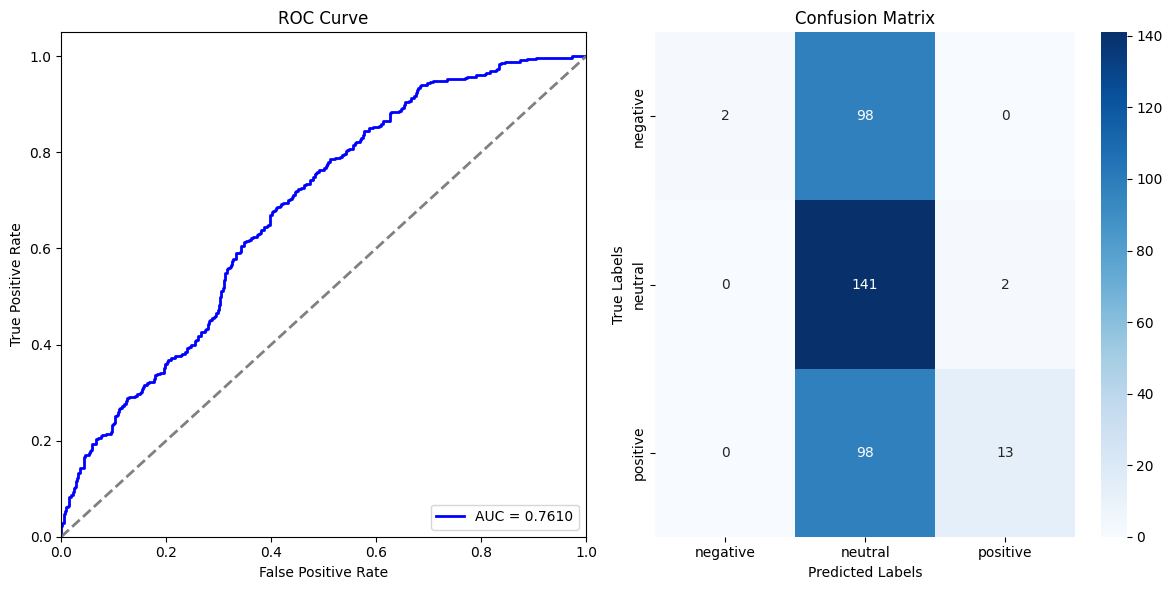

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize

# Final Evaluation on Test Set
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(X_test_tensor)
    
    # Get the predicted class labels
    _, predicted_test = torch.max(test_outputs, 1)
    
    # Compute Accuracy
    test_accuracy = accuracy_score(y_test_tensor.numpy(), predicted_test.numpy())
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")

    # Compute F1-Score (macro average for multiclass)
    f1 = f1_score(y_test_tensor.numpy(), predicted_test.numpy(), average='macro')
    print(f"Final F1-Score: {f1:.4f}")

    # Compute AUC-ROC
    y_test_bin = label_binarize(y_test_tensor.numpy(), classes=np.unique(y_train))
    
    try:
        auc_roc = roc_auc_score(y_test_bin, test_outputs.numpy(), average='macro', multi_class='ovr')
        print(f"Final AUC-ROC: {auc_roc:.4f}")

        # Plot ROC Curve for each class
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), test_outputs.numpy().ravel())  # Flatten for multi-class
        
        plt.figure(figsize=(12, 6))

        # Plot ROC Curve
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='b', lw=2, label=f'AUC = {auc_roc:.4f}')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line for random classifier
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')

        # Plot Confusion Matrix
        cm = confusion_matrix(y_test_tensor.numpy(), predicted_test.numpy())
        plt.subplot(1, 2, 2)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')

        plt.tight_layout()
        plt.show()

    except ValueError:
        # Handle case where AUC can't be computed (likely due to having a single class in predictions)
        print("AUC-ROC couldn't be computed due to the lack of multiple classes in predictions.")
